# 1. 문제 정의

캐글 타이타닉은 주어진 데이터를 학습시켜 생존자 예측 모델을 만드는 것이다. 데이터는 다음 주소에서 다운받을 수 있다.

<https://www.kaggle.com/c/titanic/data>
{: .notice--info}

분석에 필요한 패키지들을 임포트하고 데이터를 불러와보자.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


데이터는 이미 훈련용과 테스트용으로 나뉘어져 있으므로 학습을 위해 따로 분리할 필요는 없다.  
  
데이터는 타이타닉호 탑승객들의 신상정보를 series로 갖는 dataframe으로 구성되어있다. 승객별로 생존여부가 모두 라벨링되어 있으므로 타이타닉 문제는 지도학습에 해당한다. 또한 여러개의 변수를 이용하여 최종적으로 생존(1)과 사망(0)을 나눠야하는 이진 분류 문제이다.

***

# 2. 데이터 살펴보기

데이터는 학습시키기 전 전처리를 해서 깨끗한 상태로 정제해야한다. 이를 위해 데이터의 형태와 크기를 알아보고 결측치를 파악하여 어떠한 형태로 가공할 것인지 방향을 정한다.

## 2.1 데이터 딕셔너리
데이터의 각 column은 `Name`, `Age` 등 직관적으로 파악이 되는 경우도 있지만 `SibSp`, `Parch` 와 같이 의미하는바가 명확하지 않은 경우도 있다. 각 column이 의미하는 바는 캐글에서 제공하는 데이터 딕셔너리를 통해 알 수 있다.

<https://www.kaggle.com/c/titanic/data>
{: .notice--info}

위 링크로 들어가면 아래와 같이 각 데이터들에 대한 설명이 있다.

|Variable|	Definition|	Key|
|---|---|---|
|survival|	생존여부|	0 = No, 1 = Yes|
|pclass|	사회-경제적 지위 |	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|	성별	|
|Age|	나이	|
|sibsp|	타이타닉호에 탑승한 형제-자매 수	|
|parch|	타이타닉호에 탑승한 부모-자녀 수	|
|ticket|	티켓 번호	|
|fare|	탑승 요금	|
|cabin|	방 번호	|
|embarked|	탑승 지역(항구 위치)|	C = Cherbourg, Q = Queenstown, S = Southampton|

# 2.2 결측치 파악
  
  
우선 데이터의 형태를 알아보자.

In [3]:
train.shape

(891, 12)

In [4]:
test.shape

(418, 11)

훈련 데이터는 891개의 행과 12개의 열로 이루어져 있다. 테스트 데이터는 훈련 데이터로 학습시킨 모델을 통해 라벨링을 해야하므로 타깃(라벨)에 해당하는 `Survived` 열이 빠진 상태이다.  
  
조금 더 자세한 정보를 파악하기 위해 다음 명령어를 입력해보자.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


`info()`는 dataframe에 대해 각 series(column)의 타입(정수, 실수, 문자 등)과 결측치 개수의 정보를 요약해서 보여준다. 결측치가 정확히 몇개인지는 아래 코드를 통해 알 수 있다.

pandas의 `info()` 메서드는 dataframe에만 적용할 수 있고 series에는 쓸 수 없다.
{: .notice--info}

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# 2.3 데이터 시각화

각 column들을 시각화하여 대략적인 분포를 파악하고 타겟(생존여부)과의 상관관계를 유추한다. 우선 명목형, 이산형 데이터들에 대해 막대그래프를 그려주는 함수를 하나 정의한다.

In [15]:
def bar_chart(feature):
    # 각 column(=feature)에서 생존자 수 count
    survived = train[train['Survived']==1][feature].value_counts()
    
    # 각 column(=feature)에서 사망자 수 count
    dead = train[train['Survived']==0][feature].value_counts()
    
    # 생존자수, 사망자수를 하나의 dataframe으로 묶는다.
    df = pd.DataFrame([survived, dead])
    
    # 묶은 dataframe의 인덱스명(행 이름)을 지정한다.
    df.index = ['Survived', 'Dead']
    
    # plot을 그린다.
    df.plot(kind='bar', stacked=True, figsize=(10,5))
#     return df

pandas의 `value_counts()` 메서드는 dataframe에는 적용할 수 없고 series에 적용한다. 해당 메서드의 return값 역시 series이다.  
{: .notice--info}
  
pandas의 메서드 문법에 대해 자세히 알고 싶다면 다음 사이트에서 검색기능을 이용하면 된다.

<https://pandas.pydata.org/pandas-docs/stable/index.html>
{: .notice--info}

명목, 이산형 데이터에 해당하는 feature들의 그래프를 그려보자. `SibSp`와 `Parch`는 의미상 큰 차이가 없으므로 하나만 그린다.

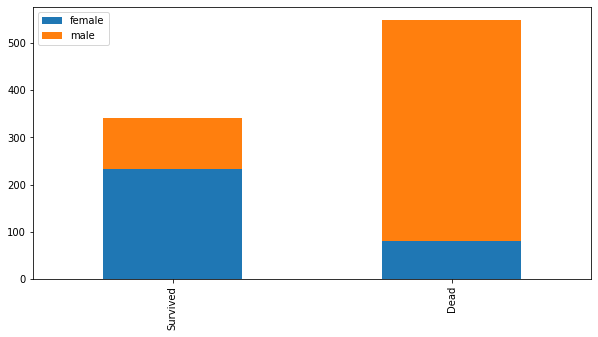

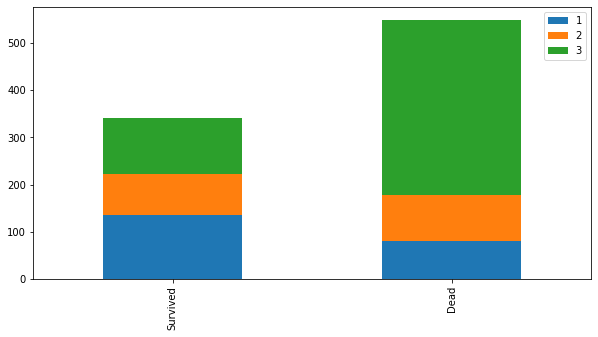

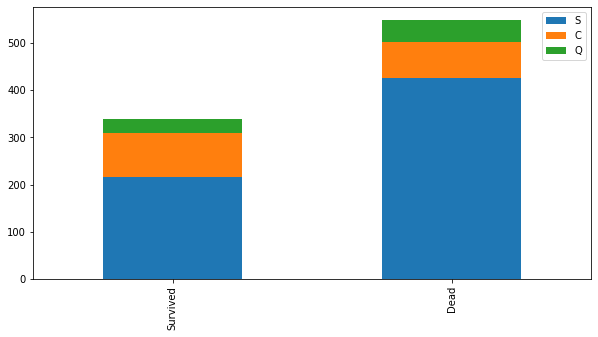

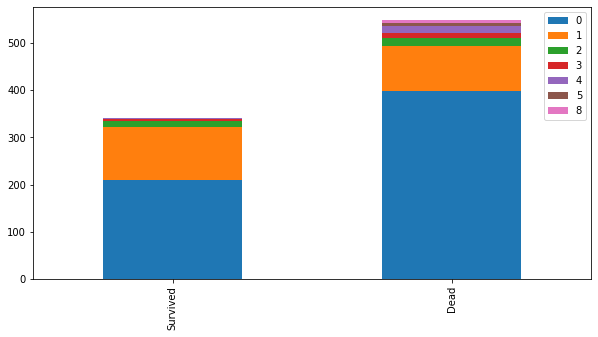

In [17]:
bar_chart('Sex')
bar_chart('Pclass')
bar_chart('Embarked')
bar_chart('SibSp')

데이터를 시각화하여 살펴본 결과 남성보단 여성이 많이 생존했으며 1등급 승객, 가족이 있는 승객이 생존율이 높았다. 탑승 지역에서의 특별한 경향은 아직 보인다고 말하긴 어려워 보이나 일단 비율상으로는 S 승객들이 많이 사망했다.

***

# 3. 데이터 전처리

정제가 필요한 column들에 대해서 전처리를 진행한다.

## 3.1 Sex

성별 데이터는 결측치가 없고 분류도 이미 끝나있다. 학습이 잘 진행될 수 있도록 각 문자들을 숫자에 대응시킨다.

In [43]:
train_test_data = [train, test]

sex_mapping = {"male":0, "female":1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

train과 test 데이터 모두 전처리를 해야 하므로 하나의 리스트를 묶어 for문을 통해 한꺼번에 처리하도록 한다. 제대로 대응이 됐는지 확인해보자.

In [44]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


## 3.2 SibSp & Parch

해당 컬럼이 의미하는 바는 결국 가족의 수이다. 앞선 시각화에서 관찰했듯이 동승자의 여부는 생존율과 유의미한 관계가 있으므로 `SisSp`와 `Parch`를 `Familysize`로 묶는다. 그리고 이를 통해 동승자 여부를 판단하는 `IsAlone`이라는 변수를 생성한다.

In [45]:
for dataset in train_test_data:
    # 가족수 = 형제자매 + 부모님 + 자녀 + 본인
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1
    
    # 가족수 > 1이면 동승자 있음
    dataset.loc[dataset['FamilySize'] > 1, 'IsAlone'] = 0

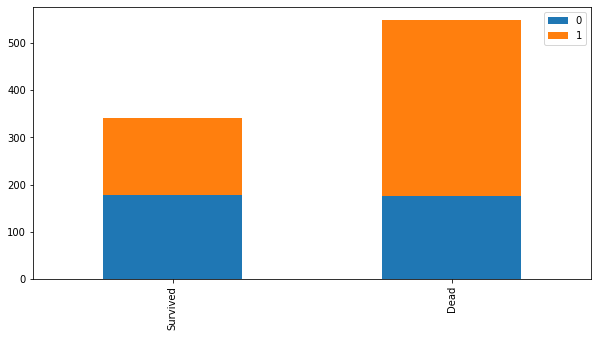

In [46]:
bar_chart('IsAlone')

위에서 확인한대로 혼자 탄 사람이 많이 사망했음을 알 수 있다. 전처리가 되어있는지 확인해보자.

In [47]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,1


# 3.3 Embarked

시각화 결과 S승객들이 사망한 비율이 높았다. 거주지역의 차이가 경제적 지표를 나타낼 수도 있으므로 등급별 승객들의 지역 분포를 시각화해서 살펴보자.

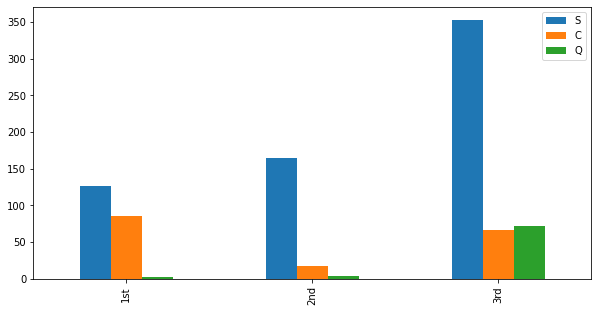

In [48]:
class_list=[]
for i in range(1,4):
    series = train[train['Pclass'] == i]['Embarked'].value_counts()
    class_list.append(series)

df = pd.DataFrame(class_list)
df.index = ['1st', '2nd', '3rd']
df.plot(kind="bar", figsize=(10,5))

Q지역이 비교적 다른지역보다 못사는 것으로 보인다. 그러나 대부분의 승객이 S지역에서 탑승했으므로 `Embarked`의 결측치는 S로 채운다.

In [49]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

성별과 마찬가지로 탑승 지역을 숫자에 매핑하고 결과를 확인한다.

In [50]:
embarked_mapping = {'S':0, 'C':1, 'Q':2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)
    
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1


# 3.4 Name

이름 자체가 생존율과 유의미한 관계가 있다고 보기는 어렵다. 그러나 서양인들의 이름은 그 사람의 성별(Mr, Mrs), 혼인 여부(Miss)를 포함한다. 성별은 그 자체로 생존율과 관계가 있고, 혼인 여부는 동승 여부를 어느정도 반영하고 있으므로 해당 부분만 추출한다. 대표적인 영어 호칭에 대한 내용은 다음과 같다.

|호칭| 설명|
|:---|:---|
|Mr.| 성인 남성|
|Mrs.| 결혼을 한 여성|
|Ms. |결혼 여부를 밝히고 싶지 않을 때 사용하는 여성 호칭|
|Miss |결혼을 하지 않은 여성|
|Master | 결혼을 하지 않은 남성. 주로 청소년 이하|

In [51]:
for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract('([\w]+)\.', expand=False)

pandas의 `str.extract()` 메서드에서 파라미터 `expand=True` 일땐 결과값으로 Dataframe을 출력하고, `expand=False`이면 결과값으로 series 또는 index를 추출한다. 우리가 필요한 것은 series이므로 해당 파라미터는 False로 택한다.
{: .notice--info}

`Name` 열에서 정규표현식 `([\w]+)\.` 에 해당하는 부분을 추출하여 `Title`이라는 series를 만들었다. 정규표현식이란 텍스트 내에서 특정 문자나 숫자, 기호 등을 지칭하는 규칙이라고 생각하면 된다. 정규표현식에 대한 자세한 문법은 다음 링크를 참고하자.

<https://wikidocs.net/21703>
{: .notice--info}

정규표현식을 제대로 사용했는지 확인하고 싶으면 다음 사이트를 이용하면 된다. 현재 작업중인 텍스트에 대해 실시간으로 정규표현식에 해당하는 문구를 색칠하여 보여준다.

<https://regexr.com/>
{: .notice--info}

train.csv 파일을 열어 Name 열에서 데이터를 적당히 복사하여 해당 사이트의 Text 란에 붙여넣어보자.

![](https://github.com/romanticq/romanticq.github.io/blob/master/assets/images/kaggle-titanic/regexr.png?raw=true)

Expression 란에 입력한 정규표현식이 Text란의 글에서 어떤 문구를 지칭하는지 색칠하여 실시간으로 나타낸다. Tools 란에서는 Expression에 사용된 정규표현식의 각 문법에 대한 설명이 기재되어있다.  
  
우리가 추출하고 싶은 호칭(Mr, Miss)들은 모두 마침표(.)로 끝난다는 공통점이 있으므로 정규표현식을 통해 이를 지정한 것이다.  
역슬래시를 포함한 `\w`는 숫자를 포함한 임의의 문자(공백, 기호, 특수문자 제외)를 지칭하고 `\.`은 마침표(.) 자체를 의미한다.

제대로 추출되어 Title열에 저장되었는지 확인하자.

In [52]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,Mr


영어 호칭의 종류 및 분포를 확인하기 위해 `value_counts()` 메서드를 이용한다.

In [53]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Jonkheer      1
Countess      1
Capt          1
Lady          1
Don           1
Sir           1
Ms            1
Mme           1
Name: Title, dtype: int64

In [54]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64

성별, 지역과 마찬가지로 각 호칭들을 숫자에 매핑한다. Mr, Miss, Mrs, Master가 대부분을 차지하고 있으므로 나머지 호칭에 대해서는 하나로 취급한다.

In [55]:
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].apply(lambda x: 0 if x=="Mr" else 1 if x=="Miss" else 2 if x=="Mrs" else 3 if x=="Master" else 4)

pandas의 `apply` 매서드는 series, dataframe의 각 entry에 접근하여 특별한 조작을 하고 싶을 때 많이 이용한다. series에 매서드를 적용하면 리턴값은 보통 series이지만 어떤 조작을 하느냐에 따라 dataframe이 출력될 수도 있다. dataframe에 대해서도 결과값은 series이거나 dataframe이다.
{: .notice--info}
  
apply에서는 `lambda`를 이용할 수 있는데 `lambda 변수명 : 변수에 대한 조작 내용` 으로 이용한다. 위의 코드를 기준으로 lambda 다음에 오는 `x`는 우리가 접근하고자 하는 Title series의 성분 하나 하나를 의미한다.
{: .notice--info}

각 호칭들을 숫자에 매핑시키고 나서 다시 한번 분포를 확인한 뒤 시각화를 진행한다.

In [56]:
train['Title'].value_counts()

0    517
1    182
2    125
3     40
4     27
Name: Title, dtype: int64

In [57]:
test['Title'].value_counts()

0    240
1     78
2     72
3     21
4      7
Name: Title, dtype: int64

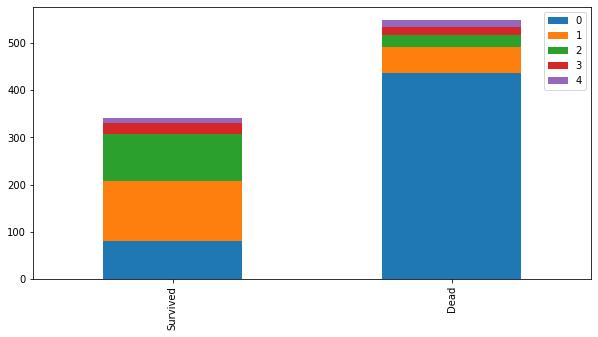

In [58]:
bar_chart('Title')

성인 남성에 해당하는 Mr가 압도적으로 사망률이 높으며, 여성에 해당하는 Miss와 Mrs는 많이 생존하였으나 가족이 없는 Miss쪽이 생존율이 더 낮은 것을 확인할 수 있다. Master는 남성이지만 어린 아이가 많아 사망률보다 생존률이 더 높다. 매핑이 잘 이루어졌는지 확인해보자.

In [59]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,0,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,0,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,0


## 3.5 Cabin

Cabin은 방 번호이다. 데이터가 어떻게 구성되어 있는지 살펴보자

In [60]:
train['Cabin'].value_counts()

B96 B98        4
C23 C25 C27    4
G6             4
E101           3
F33            3
              ..
D49            1
B69            1
E17            1
C45            1
A6             1
Name: Cabin, Length: 147, dtype: int64

숫자 정보는 제외하고 알파벳만 추출한다.

In [61]:
train['Cabin'] = train['Cabin'].str[:1]

가족 단위로 비슷한 방번호를 부여받았으니 선실이 같으면 같은 등급의 클래스일 가능성이 높을 것이다. 알파벳과 클래스와의 상관관계를 시각화하여 살펴보자.

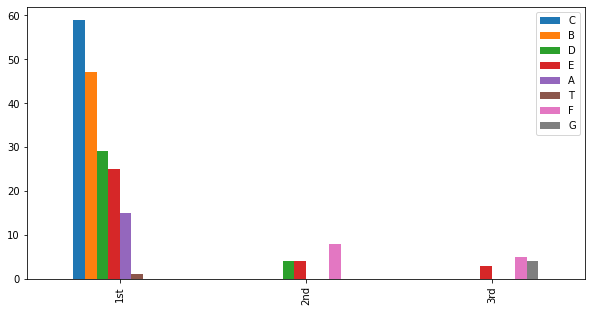

In [62]:
class_list=[]
for i in range(1,4):
    a = train[train['Pclass'] == i]['Cabin'].value_counts()
    class_list.append(a)

df = pd.DataFrame(class_list)
df.index = ['1st', '2nd', '3rd']
df.plot(kind="bar", figsize=(10,5))

우선 1등급과 3등급은 공유하는 알파벳이 없다. 그러나 cabin에 대한 정보는 결측치가 과반수 이상이고 그마저도 1등급에 매우 편향되어있다.  
  
등급별 생존율을 살펴보면, 1등급은 생존율이 더 높으며 2등급은 비슷하고 3등급은 사망률이 더 높다. 등급별 cabin 데이터의 유실률은 이를 제대로 반영하고 있지 않으므로 삭제 처리한다.



# 3.6 Age

나이 정보엔 결측치가 존재한다. 우선 승객들 전원의 평균으로 채워넣는 방법을 생각해볼 수 있다. 그러나 승객들의 Title이 나이대를 어느정도 반영하고 있으므로 각 Title에 해당하는 그룹의 중간값으로 결측치를 메꾼다.

In [63]:
for dataset in train_test_data:
    dataset['Age'].fillna(dataset.groupby("Title")["Age"].transform("median"), inplace=True)

pandas의 `fillna` 메서드에서 파라미터 `inplace=True`로 할 경우 해당 series에 결측치가 직접 채워진다. `inplace=False`일 경우 결측치가 채워진 새로운 series가 리턴된다.  
<br>
`fillna`는 dataframe, series에 둘 다 사용 가능하다.
{: .notice--info}

결측치를 모두 채웠으니 나이대별로 그룹화하자. 그룹화 기준을 판단하기 위해 그래프를 그려 분포를 확인한다.

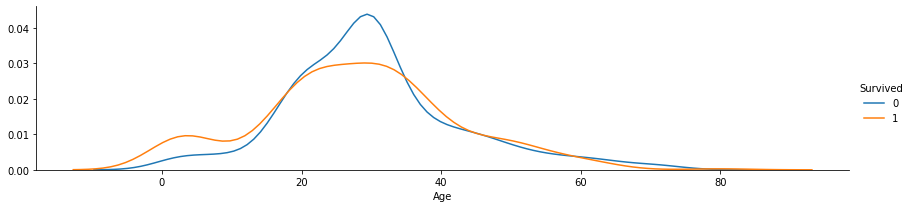

In [64]:
g = sns.FacetGrid(train, hue="Survived", aspect=4)
g = (g.map(sns.kdeplot, "Age").add_legend()) # add_legend()는 범주를 추가하는 파라미터이다.

grouping 기준은 여러가지가 있을 수 있다. 생존그래프와 사망그래프의 교점을 기준으로 할 수도 있겠지만 두 그래프의 교점을 파악하는 방법을 아직 찾지 못했다. 또한 해당 교점은 train 데이터만을 설명하는 너무 특수한 기준일 수 있다.  

그래프의 분포가 정규분포와 유사하므로 승객들을 동일 구간 기준으로 흔히 사용하는 기준인 "청소년, 청년, 중년, 장년, 노년" 5개의 집단으로 나눈다.

In [66]:
for dataset in train_test_data:
    dataset['Agebin'] = pd.cut(dataset['Age'], 5, labels=[0,1,2,3,4])

pandas의 `cut` 메서드는 array를 인수로 받아 `길이`를 기준으로 데이터를 나눈다. 일반적으로 np.array 또는 pd.series가 인수로 들어온다. `labels` 파라미터는 데이터를 나눈 뒤 이름을 부여한다.  
<br>
pandas의 `qcut` 메서드는 `cut`과 유사하며 `개수`를 기준으로 데이터를 나누는 점이 다르다.
{: .notice--info}

데이터가 잘 나누어졌는지 확인하자.

In [67]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,Agebin
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,1,2,0,2,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C,0,2,0,2,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,0,2


직접 데이터가 나뉘는 지점을 정해서 나누고 싶다면 다음 코드를 실행하면 된다. 여기서는 이용하지 않는다.

In [147]:
for dataset in train_test_data:
    dataset.loc[dataset['Age'] <= 15, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 15) & (dataset['Age'] <= 25), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <= 35), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 35) & (dataset['Age'] <= 45), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 45) & (dataset['Age'] <= 60), 'Age'] = 4
    dataset.loc[dataset['Age'] > 60, 'Age'] = 5

# 3.7 Fare

탑승요금은 높은 등급의 승객일수록 높다. 따라서 `Fare`의 결측치는 각 승객 등급별 중간값으로 채운다.

In [68]:
for dataset in train_test_data:
    dataset["Fare"].fillna(dataset.groupby("Pclass")["Fare"].transform("median"), inplace=True)

그래프를 그려 그룹화의 기준을 찾는다.

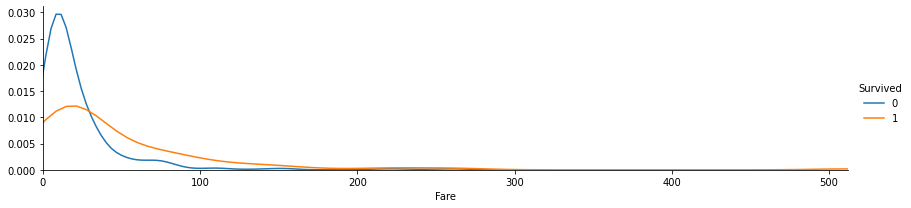

In [69]:
g = sns.FacetGrid(train, hue="Survived", aspect=4)
g = (g.map(sns.kdeplot, "Fare")
     .add_legend() # 범주 추가
     .set(xlim=(0, train['Fare'].max()))) # x축 범위 설정

승객별로 탑승요금의 편차가 굉장히 크고 분포는 우측 꼬리가 길게 편향되어 있다. 따라서 데이터를 그룹화할때 `길이`가 아닌 `개수`를 기준으로 나눈다음 `Farebin`이라는 열에 저장한다.

In [70]:
for dataset in train_test_data:
    dataset['Farebin'] = pd.qcut(dataset['Fare'], 4, labels=[0,1,2,3])

구간이 어떤 값을 기준으로 나눠졌는지 알고 싶다면 다음으로 확인하면 된다.

In [71]:
pd.qcut(train['Fare'], 4)

0       (-0.001, 7.91]
1      (31.0, 512.329]
2       (7.91, 14.454]
3      (31.0, 512.329]
4       (7.91, 14.454]
            ...       
886     (7.91, 14.454]
887     (14.454, 31.0]
888     (14.454, 31.0]
889     (14.454, 31.0]
890     (-0.001, 7.91]
Name: Fare, Length: 891, dtype: category
Categories (4, interval[float64]): [(-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]]

`Farebin`이 잘 만들어졌는지 확인해보자.

In [72]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,Agebin,Farebin
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,1,2,0,2,2,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C,0,2,0,2,2,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,0,2,1


전처리가 끝났거나 훈련에 이용하지 않을 column은 삭제한다.

In [73]:
drop_column = ['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin']

for dataset in train_test_data:
    dataset = dataset.drop(drop_column, axis=1, inplace=True)

pandas의 `drop` 매서드는 index(행) 혹은 series(열) 이름을 인수로 받아 해당하는 행 또는 열을 삭제한다. `axis` 파라미터는 0일경우 행, 1일 경우 열을 의미한다.
{: .notice--info}

제대로 삭제되었는지 확인하자.

In [74]:
train.head()

,PassengerId,Survived,Pclass,Sex,Embarked,FamilySize,IsAlone,Title,Agebin,Farebin
0,1,0,3,0,0,2,0,0,1,0
1,2,1,1,1,1,2,0,2,2,3
2,3,1,3,1,0,1,1,1,1,1
3,4,1,1,1,0,2,0,2,2,3
4,5,0,3,0,0,1,1,0,2,1


각 feature들에 대한 전처리는 이것으로 완료되었다. 결측치가 제대로 채워졌는지 마지막으로 확인한다.

In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Sex          891 non-null    int64   
 4   Embarked     891 non-null    int64   
 5   FamilySize   891 non-null    int64   
 6   IsAlone      891 non-null    int64   
 7   Title        891 non-null    int64   
 8   Agebin       891 non-null    category
 9   Farebin      891 non-null    category
dtypes: category(2), int64(8)
memory usage: 57.9 KB


In [76]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int64   
 1   Pclass       418 non-null    int64   
 2   Sex          418 non-null    int64   
 3   Embarked     418 non-null    int64   
 4   FamilySize   418 non-null    int64   
 5   IsAlone      418 non-null    int64   
 6   Title        418 non-null    int64   
 7   Agebin       418 non-null    category
 8   Farebin      418 non-null    category
dtypes: category(2), int64(7)
memory usage: 24.2 KB


***

# 4. 데이터 학습

`PassengerId`는 승객들 연번에 불과하므로 학습시키지 않는다. `Survived`역시 결과에 해당하므로 학습시켜선 안된다. 따로 떼어서 target에 저장하고 훈련 데이터에선 삭제한다.

In [77]:
drop_column2 = ['PassengerId', 'Survived']
train_data = train.drop(drop_column2, axis=1)
target = train['Survived']

데이터 학습, 모델 생성 및 평가에 필요한 패키지들을 import 한다. 데이터 분류에 이용할 수 있는 기법인 `의사결정나무`, `랜덤포레스트`, `나이브 베이즈 분류`, `서포트 벡터 머신`, `로지스틱 회귀` 다섯개를 이용하여 모델을 생성한다. 생성된 모델 중 가장 점수가 높은 것을 kaggle에 제출할 것이다.

In [79]:
from sklearn.tree import DecisionTreeClassifier # 의사결정나무
from sklearn.ensemble import RandomForestClassifier # 랜덤 포레스트
from sklearn.naive_bayes import GaussianNB # 나이브 베이즈 분류
from sklearn.svm import SVC # 서포트 벡터 머신
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀

In [80]:
clf = LogisticRegression()
clf.fit(train_data, target)
clf.score(train_data, target)

0.8103254769921436

In [82]:
clf = DecisionTreeClassifier()
clf.fit(train_data, target)
clf.score(train_data, target)

0.8900112233445566

In [83]:
clf = RandomForestClassifier()
clf.fit(train_data, target)
clf.score(train_data, target)

0.8900112233445566

In [84]:
clf = GaussianNB()
clf.fit(train_data, target)
clf.score(train_data, target)

0.7968574635241302

In [85]:
clf = SVC()
clf.fit(train_data, target)
clf.score(train_data, target)

0.8338945005611672

의사결정나무가 점수가 가장 높으므로 해당 모델을 테스트 데이터에 적용한다.

In [86]:
clf = DecisionTreeClassifier()
clf.fit(train_data, target)
test_data = test.drop("PassengerId", axis=1)
predict = clf.predict(test_data)

test 데이터에서도 train과 마찬가지로 `PassengerId`는 삭제한다. test 데이터를 모델에 적용해서 예측한 결과를 predict에 저장한다.

In [87]:
submission = pd.DataFrame({
    'PassengerId' : test['PassengerId'],
    'Survived' : predict})

submission.to_csv('submission.csv', index=False)

예측 결과를 `PassengerId`와 매치시켜 dataframe으로 묶은 뒤 csv파일로 저장한다.

In [297]:
submission = pd.read_csv("submission.csv")
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


제대로 저장되었는지 확인해본다.

***

# 5. 결과

![](https://github.com/romanticq/romanticq.github.io/blob/master/assets/images/kaggle-titanic/score.png?raw=true)

78점을 받았다.

![](https://github.com/romanticq/romanticq.github.io/blob/master/assets/images/kaggle-titanic/rank.png?raw=true)

상위 29%에 해당하는 점수이다.

***

# 6. 한계점

타이타닉 문제를 진행하면서 느낀 한계점은 다음과 같다.

변수들 사이의 상관관계를 반영했는가?
{: .notice--success}

학습에 이용된 변수들 사이에는 분명히 상관관계가 존재한다. 이번 문제에서는 데이터 전처리의 근거를 시각화를 통한 경향 파악만으로 진행하였다. 변수들 사이의 상관관계를 파악하는 다양한 통계적 기법을 적용하지 못한 점이 아쉽다.

데이터를 학습시킬 때 파라미터를 적절히 조절하였는가?
{: .notice--success}

사이킷런 패키지를 통해 구현된 학습 모델들은 여러가지 파라미터들이 존재한다. 가령 로지스틱회귀를 이용할 때 어떤 부분들을 조절할 수 있는지는 다음 링크에서 확인할 수 있다.

<https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression>
{: .notice--info}

아직 학습 모델의 알고리즘을 정확하게 이해한 상태가 아니라 이번 문제에서는 default로 설정된 파라미터들만을 이용하여 진행했다. 파라미터들을 적절히 조절할 수 있다면 더 높은 성능의 모델이 생성될 것으로 기대된다.


# 참고

<https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy>  
<br>
<https://cyc1am3n.github.io/2018/10/09/my-first-kaggle-competition_titanic.html>  
<br>
<https://nonmeyet.tistory.com/entry/Python-%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89-%EC%83%9D%EC%A1%B4%EC%9E%90-%EC%98%88%EC%B8%A1%EB%AA%A8%ED%98%95-%EB%A7%8C%EB%93%A4%EA%B8%B0-Kaggle-%EC%BC%80%EA%B8%80-%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC-1>  
<br>
<https://jfun.tistory.com/136>
{: .notice--info}